# Análise de dados - Netflix 

Essa análise de dados foi feita utilizando um conjunto de dados coletado do Flixable, um mecanismo de pesquisa de terceiros da Netflix.

---
# Dados

- **'show_id'**: ID único para cada filme / programa de TV.
- **'type'**: se é filme ou programa de TV.
- **'title'**: Título do filme / programa de TV.
- **'director'**: Diretor do filme/ programa de TV.
- **'cast'**: Atores envolvidos no filme/ programa de TV.
- **'country'**: País onde o filme/ programa de TV foi produzido.
- **'date_added'**: Data em que foi adicionado ao Netflix.
- **'release_year'**: Ano de lançamento real do filme/ programa de TV.
- **'rating'**: Classificação do filme/ programa de TV.
- **'duration'**: Duração total - em minutos ou em números de temporadas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from pandas_profiling import ProfileReport
from scipy.stats import norm
from sklearn.preprocessing import MultiLabelBinarizer
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('../input/netflix-data/netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


## df.info()

In [3]:
report = ProfileReport(df)
report

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Limpeza de Dados

In [4]:
df.nunique()

show_id         7787
type               2
title           7787
director        4049
cast            6831
country          681
date_added      1565
release_year      73
rating            14
duration         216
listed_in        492
description     7769
dtype: int64

In [5]:
df.isna().sum()

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

**director** e **cast**: não são necessárias para a análise (sem muita informação).

**country**: é uma variável importante,então será necessário corrigi-lá. 

**date_added** : Não foi possível achar os valores para esta coluna na internet, então as linhas que não contêm o valor serão descartadas, pois são apenas 11.

**rating** : os dados para esta coluna pode ser encontrados na Amazon ranting.

### Rating

In [6]:
df[df['rating'].isna()]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
67,s68,Movie,13TH: A Conversation with Oprah Winfrey & Ava ...,NaN,"Oprah Winfrey, Ava DuVernay",NaN,"January 26, 2017",2017,NaN,37 min,Movies,Oprah Winfrey sits down with director Ava DuVe...
2359,s2360,TV Show,Gargantia on the Verdurous Planet,NaN,"Kaito Ishikawa, Hisako Kanemoto, Ai Kayano, Ka...",Japan,"December 1, 2016",2013,NaN,1 Season,"Anime Series, International TV Shows","After falling through a wormhole, a space-dwel..."
3660,s3661,TV Show,Little Lunch,NaN,"Flynn Curry, Olivia Deeble, Madison Lu, Oisín ...",Australia,"February 1, 2018",2015,NaN,1 Season,"Kids' TV, TV Comedies","Adopting a child's perspective, this show take..."
3736,s3737,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,NaN,74 min,Movies,"Louis C.K. muses on religion, eternal love, gi..."
3737,s3738,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,NaN,84 min,Movies,Emmy-winning comedy writer Louis C.K. brings h...
3738,s3739,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,"August 15, 2016",2015,NaN,66 min,Movies,The comic puts his trademark hilarious/thought...
4323,s4324,Movie,My Honor Was Loyalty,Alessandro Pepe,"Leone Frisa, Paolo Vaccarino, Francesco Miglio...",Italy,"March 1, 2017",2015,NaN,115 min,Dramas,"Amid the chaos and horror of World War II, a c..."


In [7]:
rating_replacements = {
    67: 'TV-PG',
    2359: 'TV-14',
    3660: 'TV-MA',
    3736: 'TV-MA',
    3737: 'NR',
    3738: 'TV-MA',
    4323: 'TV-MA '
}

for id, rate in rating_replacements.items():
    df.iloc[id, 8] = rate

df['rating'].isna().sum()

0

### Director e Cast

In [8]:
df = df.drop(['director', 'cast'], axis=1)

### date_added 

In [9]:
df = df[df['date_added'].notna()]

### Country
-  os valores nulos serão trocados pelo país com maior numero de repetições na coluna.

In [10]:
df['country'] = df['country'].fillna(df['country'].mode()[0])

##  Verificando se os dados estão limpos

In [11]:
df.isna().sum()

show_id         0
type            0
title           0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

# Cirando novas colunas com base em variáveis

### Datas
- Pra uma melhor visualização das datas elas sarão separadas em 3 colunas:
ano_adicionado, mes_adicionado e trimestre_adicionado.

In [12]:
df['ano_adicionado'] = pd.DatetimeIndex(df['date_added']).year
df['mes_adicionado'] = pd.DatetimeIndex(df['date_added']).month
df['trimestre_adicionado'] = pd.DatetimeIndex(df['date_added']).quarter

### Público alvo
- o público alvo será definido com base na Classificação Indicativa (rating).

In [13]:
classificacao_indicativa = {
    'TV-PG': 'Crianças mais velhas',
    'TV-MA': 'Adultos',
    'TV-MA ': 'Adultos',
    'TV-Y7-FV': 'Crianças mais velhas',
    'TV-Y7': 'Crianças mais velhas',
    'TV-14': 'Adolescentes',
    'R': 'Adultos',
    'TV-Y': 'Crianças',
    'NR': 'Adultos',
    'PG-13': 'Adolescentes',
    'TV-G': 'Crianças',
    'PG': 'Crianças mais velhas',
    'G': 'Crianças',
    'UR': 'Adultos',
    'NC-17': 'Adultos'
}

df['publico_alvo'] = df['rating'].replace(classificacao_indicativa)
df['publico_alvo'].unique()

array(['Adultos', 'Adolescentes', 'Crianças mais velhas', 'Crianças'],
      dtype=object)

### Country
- Em algumas linhas a coluna country contém uma lista com varios países. Para facilitar, será usado apenas o primeiro país de cada lista.

In [14]:
df['pais_principal'] = df['country'].apply(lambda x: x.split(",")[0])

### gênero
- a coluna listed_in tem os gêneros que pertencem aos filmes / programas de tv , porem eles estão juntos em apenas uma string, impossibilitando a leitura dos dados. Para que seja possível uma leitura de dados adequada é necessário separar todos os gêneros em uma nova coluna.

In [15]:
df['genero'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 

# Ajustando os dados

### Type e publico_alvo
- As colunas type e publico_alvo devem ser uma categoria.

In [16]:
df['type'] = pd.Categorical(df['type'])

df['publico_alvo'] = pd.Categorical(df['publico_alvo'], 
                                   categories=['Crianças', 'Crianças mais velhas', 
                                               'Adolescentes', 'adultos'])

### Separando filmes e programas de TV

In [17]:
df['tipo'] = df['type'].replace('TV Show','Programa de TV').replace('Movie','Filme')

filme_df = df[df['tipo'] == 'Filme']
programa_df = df[df['tipo'] == 'Programa de TV']

# Retirando colunas desnecessárias

In [18]:
df = df.drop(['type', 'date_added', 'listed_in','country','description'], axis=1)

In [19]:
df.head()

,show_id,title,release_year,rating,duration,ano_adicionado,mes_adicionado,trimestre_adicionado,publico_alvo,pais_principal,genero,tipo
0,s1,3%,2020,TV-MA,4 Seasons,2020,8,3,NaN,Brazil,"[International TV Shows, TV Dramas, TV Sci-Fi ...",Programa de TV
1,s2,7:19,2016,TV-MA,93 min,2016,12,4,NaN,Mexico,"[Dramas, International Movies]",Filme
2,s3,23:59,2011,R,78 min,2018,12,4,NaN,Singapore,"[Horror Movies, International Movies]",Filme
3,s4,9,2009,PG-13,80 min,2017,11,4,Adolescentes,United States,"[Action & Adventure, Independent Movies, Sci-F...",Filme
4,s5,21,2008,PG-13,123 min,2020,1,1,Adolescentes,United States,[Dramas],Filme


# visualização dos dados

In [20]:
fig = px.pie(df['tipo'].value_counts().reset_index(), values='tipo', names='index')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [21]:
def generate_rating_df(df):
    rating_df = df.groupby(['rating', 'publico_alvo']).agg({'show_id': 'count'}).reset_index()
    rating_df = rating_df[rating_df['show_id'] != 0]
    rating_df.columns = ['classificacao', 'publico_alvo', 'quantidade']
    rating_df = rating_df.sort_values('publico_alvo')
    return rating_df

In [22]:
rating_df = generate_rating_df(df)
fig = px.bar(rating_df, x='classificacao', y='quantidade', color='publico_alvo')
fig.show()

In [23]:
filme_classif_df = generate_rating_df(filme_df)
programa_classif_df = generate_rating_df(programa_df)

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

fig.add_trace(
    go.Pie(labels=filme_classif_df['publico_alvo'], values=filme_classif_df['quantidade']),
    row=1, col=1
)

fig.add_trace(
    go.Pie(labels=programa_classif_df['publico_alvo'], values=programa_classif_df['quantidade']),
    row=1, col=2
)

fig.update_traces(textposition='inside', hole=.4, hoverinfo="label+percent")
fig.update_layout(
    title_text="Distribuição de classificação por tipo de conteúdo",
    annotations=[dict(text='     Filmes', x=0.16, y=0.5, font_size=12, showarrow=False),
                 dict(text='Programas', x=0.82, y=0.5, font_size=12, showarrow=False)])
fig.show()

In [24]:
country_df = df['pais_principal'].value_counts().reset_index()
country_df = country_df[country_df['pais_principal'] /  country_df['pais_principal'].sum() > 0.01]

fig = px.pie(country_df, values='pais_principal', names='index')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [25]:
fig = px.histogram(df, x='pais_principal')
fig.update_xaxes(categoryorder='total descending')
fig.show()

## Distribuição do conteúdo

In [26]:
ano_lancado_df = df.loc[df['release_year'] > 2010].groupby(['release_year', 'tipo']).agg({'show_id': 'count'}).reset_index()
ano_adicionado_df = df.loc[df['ano_adicionado'] > 2010].groupby(['ano_adicionado', 'tipo']).agg({'show_id': 'count'}).reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter( 
    x=ano_lancado_df.loc[ano_lancado_df['tipo'] == 'Filme']['release_year'], 
    y=ano_lancado_df.loc[ano_lancado_df['tipo'] == 'Filme']['show_id'],
    mode='lines+markers',
    name='filme: ano de lançamento',
    marker_color='green',
))
fig.add_trace(go.Scatter( 
    x=ano_lancado_df.loc[ano_lancado_df['tipo'] == 'Programa de TV']['release_year'], 
    y=ano_lancado_df.loc[ano_lancado_df['tipo'] == 'Programa de TV']['show_id'],
    mode='lines+markers',
    name='Programa de TV: ano de lançamento',
    marker_color='darkgreen',
))
fig.add_trace(go.Scatter( 
    x=ano_adicionado_df.loc[ano_adicionado_df['tipo'] == 'Filme']['ano_adicionado'], 
    y=ano_adicionado_df.loc[ano_adicionado_df['tipo'] == 'Filme']['show_id'],
    mode='lines+markers',
    name='filme: ano de adicionado',
    marker_color='orange',
))
fig.add_trace(go.Scatter( 
    x=ano_adicionado_df.loc[ano_adicionado_df['tipo'] == 'Programa de TV']['ano_adicionado'], 
    y=ano_adicionado_df.loc[ano_adicionado_df['tipo'] == 'Programa de TV']['show_id'],
    mode='lines+markers',
    name='Programa de TV: ano adicionado',
    marker_color='darkorange',
))
fig.update_xaxes(categoryorder='total descending')
fig.show()

## Análise de gênero

In [27]:
def calculate_mlb(series):
    mlb = MultiLabelBinarizer()
    mlb_df = pd.DataFrame(mlb.fit_transform(series), columns=mlb.classes_, index=series.index)
    return mlb_df

In [28]:
def top_genres(df, title='Melhores'):
    genero_df = calculate_mlb(df['genero'])
    tdata = genero_df.sum().sort_values(ascending=False)
    
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=tdata.index,
        y=tdata.values,
    ))
    fig.update_layout(title=title)
    fig.show()

#### filmes

In [29]:
top_genres(filme_df, title='genêros mais famosos (filmes)')

In [30]:
filme_top_generos =  [
    'International Movies',
    'Dramas',
    'Comedies',
    'Documentaries',
    'Action & Adventure',
]

#### Programas

In [31]:
top_genres(programa_df, title='genêros mais famosos (programas)')

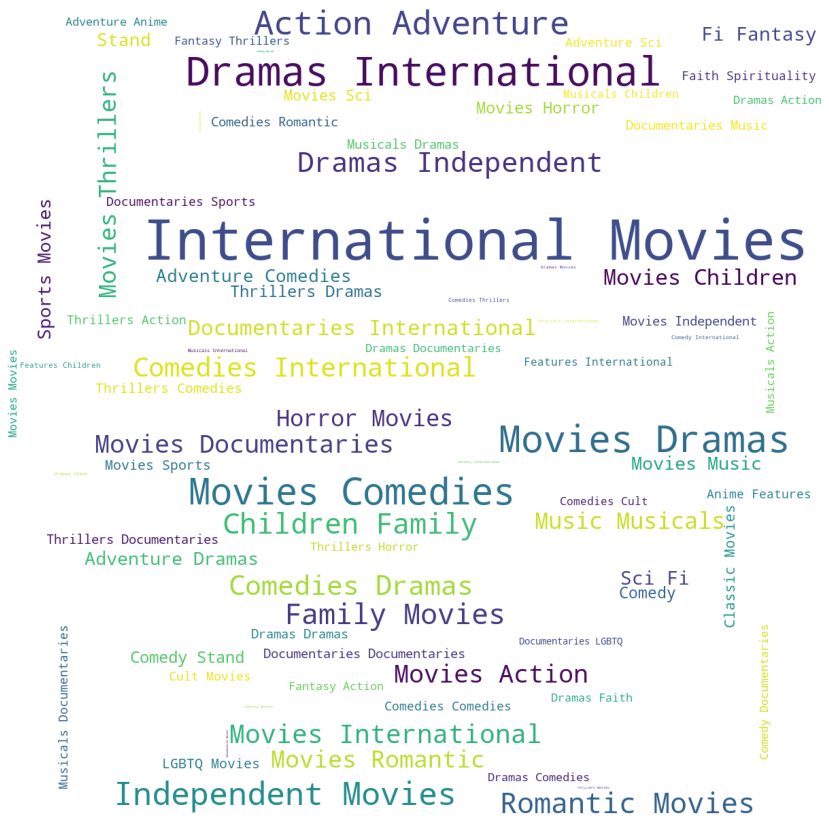

In [32]:
text = str(list(filme_df['genero'])).replace(',', '').replace('[', '').replace("'", '').replace(']', '')

plt.rcParams['figure.figsize'] = (15, 15)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Análise de duração

### Programas de TV

In [33]:
fig = px.histogram(x=programa_df['duration'])
fig.update_xaxes(categoryorder="total descending")
fig.update_layout(
    title="Distribuição da duração dos programas",
    xaxis_title="Duração do programa",
)
fig.show()

### Filmes

 a duração dos filmes será dividida em três categorias:

   - Menos de 1.30 horas.
   - Mais de 1.30 horas e menos de 2.30 horas.
   - Mais de 2.30 horas.

In [34]:
temp_duracao = filme_df['duration'].apply(lambda x: int(x.split(' ')[0]))

In [35]:
filme_df.loc[temp_duracao.loc[temp_duracao < 90].index, 'duration_bin'] = 'Menos de 1.30 horas'
filme_df.loc[temp_duracao.loc[(temp_duracao >= 90) & (temp_duracao < 150)].index, 'duration_bin'] = 'Mais de 1.30 horas e menos de 2.30 horas'
filme_df.loc[temp_duracao.loc[temp_duracao >= 150].index, 'duration_bin'] = 'Mais de 2.30 horas'

In [36]:
fig = px.histogram(x=filme_df['duration_bin'], color=filme_df['duration_bin'])
fig.update_layout(
    title="Distribuição da duração dos filmes",
    xaxis_title="Duração dos filmes",
)
fig.show()

## Lançamento do ano por gêneros

In [37]:
filme_df['genero_principal'] = filme_df['genero'].apply(lambda genres: genres[0])

In [38]:
genero_ano_df = filme_df[(filme_df['genero_principal'].isin(filme_top_generos)) & (filme_df['ano_adicionado'] >= 2017)].groupby(['genero_principal', 'ano_adicionado']).agg({'title': 'count'})
genero_ano_df = genero_ano_df.reset_index()
genero_ano_df.columns = ['genero_principal', 'ano_adicionado', 'quantidade']

fig = px.sunburst(genero_ano_df, path=['ano_adicionado', 'genero_principal'], values='quantidade')
fig.show()